## False Coloring Introduction 


#### Purpose
Render grayscale digital pathology datasets into virtual H&E color space for 3D pathology. This notebook is used to describe some of the main features of the FalseColor python package, and view the results. The main processing application of this package is color_script.py located in the scripts folder. 

#### Using this notebook

##### CPU processing
1. A dataset from the Examples/h5_sample_data folder is loaded into a DataObject class for parallel processing
2. A runnable dictionary is created which contains a 'runnable' (method) fc.falseColor, and 'kwargs' (None in this case) which will be passed to the DataObjects processImages method. The purpose of this is to have an object which possesses abstracted processing method which could apply any user-defined image processing operation in a generalized form.
3. The data is false colored using the falseColor method from coloring.py

##### GPU processing
With GPU processing there are a few more pre processing steps that occur, which happen implicitly in the CPU version.
NOTE: for using the non-flat field based fc.rapidFalseColor method additional background subtraction is unneeded.
1. Background levels are calculated and subtracted from both channels and image levels are clipped to the range of 0-65535.
2. Edges are enhanced using the sharpenImage method in coloring.py
3. The intensity leveling map for each channel is calculated and resized 
4. The images are false colored using the rapidFalseColor method from coloring.py

In [1]:
import falsecolor.coloring as fc
from falsecolor.dataobject import DataObject
import numpy as np
import os
%matplotlib notebook
import matplotlib.pyplot as plt
from falsecolor.process import ViewImage
import h5py as h5
import scipy.ndimage as nd
import skimage as sk
import copy

## CPU Processing

### DataObjects

A DataObject is a class in FalseColor Python which can hold data in memory and process that data in parallel. It is initialized with a filepath containing the image data of interest, and a number of cpu cores for parallel processing, default is 2.

DataObjects store image data in their imageSet property, which organizes multichannel data into one array. 

In [2]:
#load data in ./h5_sample_data/example_data.h5
file_path = os.path.join(os.getcwd(),'h5_sample_data/prostate')

#setup DataObject with hdf5 imageSet

Dataset = DataObject(directory = file_path) #initialize DataObject with directory set to file_path

Dataset.setupH5data() #find h5 file stored in directory and load data

print(Dataset.imageSet.shape) #display imageset shape: CZXY

(2, 16, 1024, 1024)


<IPython.core.display.Javascript object>


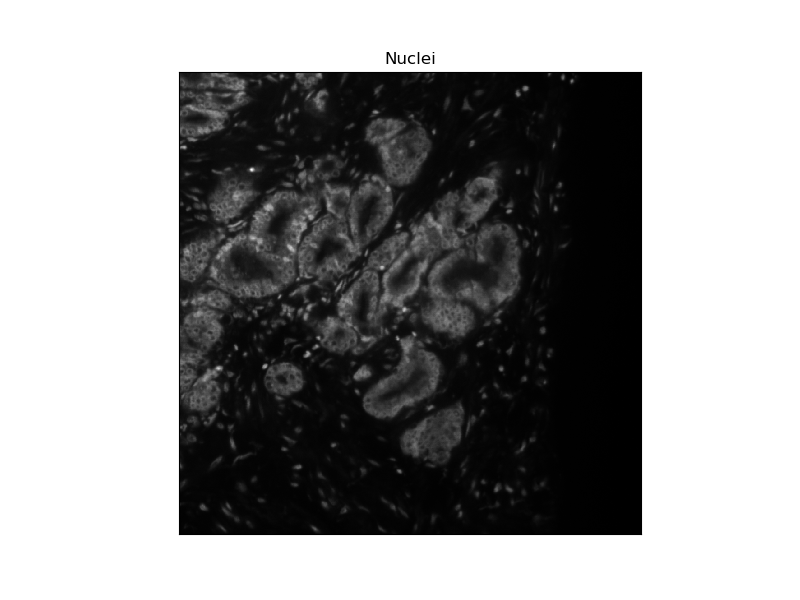

<IPython.core.display.Javascript object>


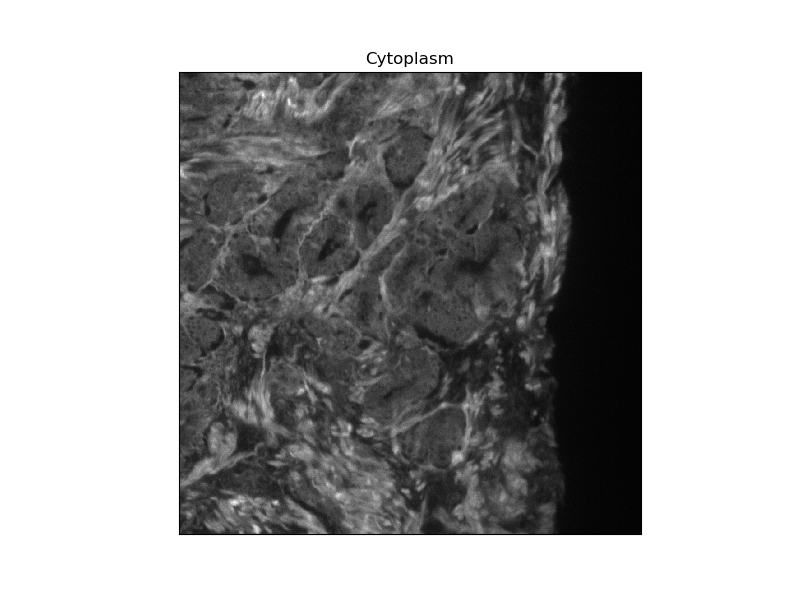

(<Figure size 800x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23d0b85f9a0>)

In [3]:
#view raw data
ViewImage(Dataset.imageSet[0,0,:,:], title = 'Nuclei', cmap = 'gray', figsize = (8,6))
ViewImage(Dataset.imageSet[1,0,:,:], title = 'Cytoplasm', cmap = 'gray', figsize = (8,6))

### Parallel Processing

DataObjects can run general image processing functions in parallel via the processImages method. processImages takes a 'runnable' as an argument, which is a dictionary containing a python method, and the keyword arguments, along with the images to process.

To use a DataObject to process images in parallel we create runnable dictionary
which includes the method we want to parallelize along with any keyword arguments.
The key, value pairs for the runnable dictionary should be:

    'runnable' : method object, the method to parallelize
    'kwargs' : dict, dictionary with key,value pairs corresponding to keyword arguments and desired settings

If the method has no keyword arguments, or if default values are ok, that entry
should be None in the dictionary.

In [4]:
#The method that will be used in parallel processing is the falseColor method from coloring.py

#falseColor includes a background subtraction, and background threshold are included as 
#keyword arguments. We can measure background levels by passing images into 
#getBackgroundLevels() in coloring.py

nuclear_background = fc.getBackgroundLevels(Dataset.imageSet[0,0])[1]
cyto_background = fc.getBackgroundLevels(Dataset.imageSet[1,0])[1]

In [5]:

color_dict = {'runnable' : fc.falseColor, #method to run in parallel, in this case the falseColor method from coloring
                 
                 'kwargs' : {'nuc_threshold' : nuclear_background, #keyword arguments can be used to adjust settings
                             'cyto_threshold' : cyto_background}  }

In [6]:

#run parallel processing on multiple CPU cores on the DataObject's imageSet
pseudo_colored_data = Dataset.processImages(color_dict, Dataset.imageSet)

#all 32 images in imageSet were converted into 16 RGB images
print(pseudo_colored_data.shape)

(16, 1024, 1024, 3)


<IPython.core.display.Javascript object>


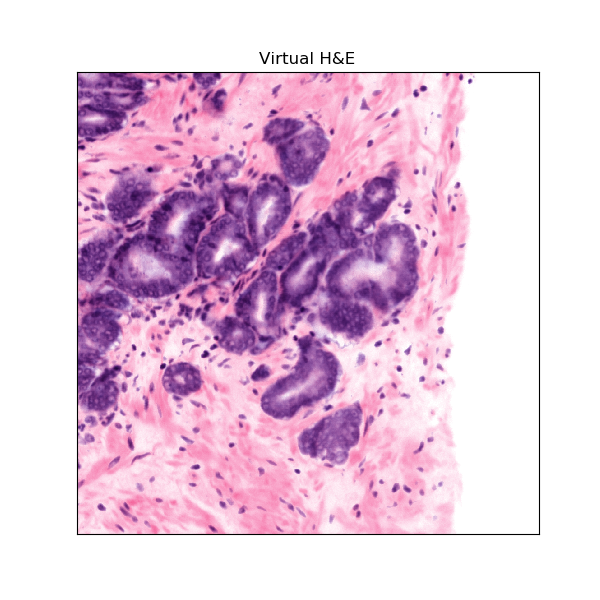

(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23d0c4e3850>)

In [7]:
#View results
ViewImage(pseudo_colored_data[0],title='Virtual H&E',figsize=(6,6))

DataObjects can also be used to parallelize GPU based methods

In [8]:
#To demonstrate we will create a runnable which uses the sharpenImage method
#in coloring.py

sharpen_dict = {'runnable' : fc.sharpenImage, 'kwargs' : None}

<IPython.core.display.Javascript object>


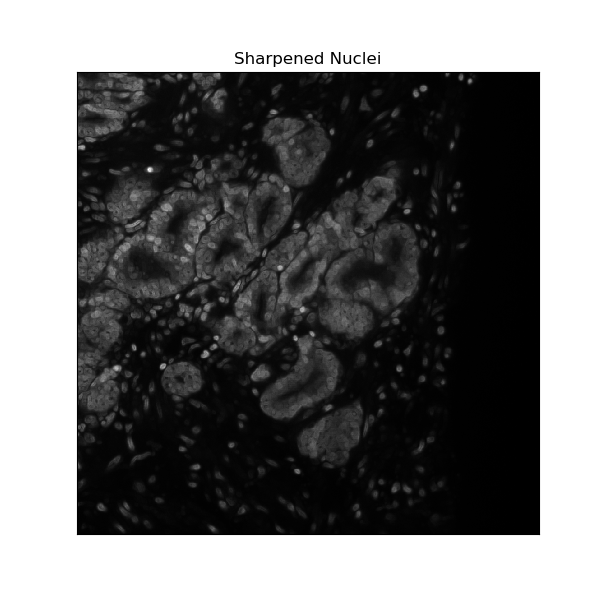

(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23d0c52a0a0>)

In [9]:
sharp_nuclei = Dataset.processImages(sharpen_dict,[Dataset.imageSet[0]])

ViewImage(sharp_nuclei[0], figsize = (6,6), cmap = 'gray', title = 'Sharpened Nuclei')

## GPU Processing

In [ ]:
#Separate data into Hematoxylin (nuclei), and Eosin (cyto) 3D arrays
#This is just because the data is already in memory
nuclei = copy.deepcopy(Dataset.imageSet[0,:,:,:]).astype(float)
cyto = copy.deepcopy(Dataset.imageSet[1,:,:,:]).astype(float)
nuclei.shape

In [ ]:
#Preprocessing

#Background subtraction and sharpening
nuc_bg = fc.getBackgroundLevels(nuclei[-1])[1]
cyto_bg = fc.getBackgroundLevels(cyto[-1])[1]

#subtract background
nuclei_nobackground = copy.deepcopy(nuclei) - nuc_bg
nuclei_nobackground = np.clip(nuclei_nobackground,0,65535)

cyto_nobackground = copy.deepcopy(cyto) - 1.0*cyto_bg
cyto_nobackground = np.clip(cyto_nobackground,0,65535)

sharp_nuclei = np.zeros(nuclei_nobackground.shape)
sharp_cyto = np.zeros(cyto_nobackground.shape)

for i in range(len(nuclei_nobackground)):
    sharp_nuclei[i] = fc.sharpenImage(nuclei_nobackground[i])
    sharp_cyto[i] = fc.sharpenImage(cyto_nobackground[i])

In [ ]:
#Calculate flat field
nuc_flatfield = fc.getFlatField(sharp_nuclei)[0]
cyto_flatfield = fc.getFlatField(sharp_cyto)[0]
print(nuc_flatfield.shape)

In [ ]:
#reshape flat field so they are the same size as image
nuc_flatfield = nd.interpolation.zoom(nuc_flatfield[0], 16, order = 1, mode = 'nearest')
cyto_flatfield = nd.interpolation.zoom(cyto_flatfield[0], 16, order = 1, mode = 'nearest')
print(nuc_flatfield.shape)

In [ ]:
#get RGB settings
settings_dict = fc.getDefaultRGBSettings()
nuclei_RGBsettings = settings_dict['nuclei']
cyto_RGBsettings = settings_dict['cyto']

In [ ]:
#execute GPU accelerated false coloring on two individual images using standard background subtraction
original_settings = fc.rapidFalseColor(sharp_nuclei[0], sharp_cyto[0],
                                       nuclei_RGBsettings, cyto_RGBsettings,
                                       run_FlatField_nuc = True, run_FlatField_cyto = True,
                                       cyto_normfactor = 3*cyto_flatfield,
                                       nuc_normfactor = 0.5*nuc_flatfield
                                       )

In [ ]:
ViewImage(original_settings,figsize=(6,6),title='False Colored Prostate')